In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Deep_Learning_Projects /archive (15).zip"  # Change this to your file's path
extract_path = "/content/drive/My Drive/satellite_extracted_files"  # Change if needed

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")


In [ ]:
!pip install split-folders


In [ ]:
import os
import cv2
import tensorflow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, Xception, InceptionResNetV2, ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import splitfolders  # Install using: pip install splitfolders
import os

# Path to your dataset (Change this to your actual path)
input_folder = "/content/drive/MyDrive/satellite_extracted_files/data"  # Main dataset folder

# Output folder for split dataset
output_folder = "/content/drive/My Drive/satellite_dataset_split"

# Create train and test sets (80% train, 20% test)
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.2), group_prefix=None, move=False)

print("Dataset split complete! Check:", output_folder)


Copying files: 5631 files [39:21,  2.38 files/s]

Dataset split complete! Check: /content/drive/My Drive/satellite_dataset_split


In [ ]:
import os
import pandas as pd  # Install using: pip install pandas

# Paths to train and test directories
train_path = "/content/drive/MyDrive/satellite_dataset_split/train"
test_path = "/content/drive/MyDrive/satellite_dataset_split/val"

# Function to count images in each category
def count_images(data_path):
    category_counts = {}
    for category in os.listdir(data_path):
        category_folder = os.path.join(data_path, category)
        if os.path.isdir(category_folder):
            num_images = len([img for img in os.listdir(category_folder) if img.endswith(".jpg")])
            category_counts[category] = num_images
    return category_counts

# Count images in train and test datasets
train_counts = count_images(train_path)
test_counts = count_images(test_path)

# Create a DataFrame for better visualization
df = pd.DataFrame({"Category": train_counts.keys(), "Train Images": train_counts.values(), "Test Images": test_counts.values()})

# Print the table
print(df)

# Display in Colab as a proper table
from IPython.display import display
display(df)


     Category  Train Images  Test Images
0      cloudy          1200          300
1      desert           904          227
2  green_area          1200          300
3       water          1200          300


,Category,Train Images,Test Images
0,cloudy,1200,300
1,desert,904,227
2,green_area,1200,300
3,water,1200,300


## Preprocessing Data

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Define paths
dataset_path = "/content/drive/MyDrive/satellite_dataset_split/train"  # Change if needed

# Define image size and categories
IMG_SIZE = (128, 128)  # Resize all images to 128x128
categories = ["cloudy", "desert", "green_area", "water"]  # Class labels

# Create empty lists for images and labels
X = []  # Image data
y = []  # Labels

# Load and preprocess images
for label, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)

    if os.path.isdir(category_path):  # Ensure it's a folder
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)

            if img_name.lower().endswith((".jpg", ".png", ".jpeg")):  # Process only image files
                img = cv2.imread(img_path)  # Read image

                if img is not None:  # Ensure image is loaded correctly
                    img = cv2.resize(img, IMG_SIZE)  # Resize
                    img = img / 255.0  # Normalize pixel values to [0,1]

                    X.append(img)
                    y.append(label)  # Convert category name to a number
                else:
                    print(f"Skipping invalid image: {img_path}")  # Debugging message

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# **Important**: Stratify using raw labels before one-hot encoding
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# One-hot encode labels AFTER splitting
y_train = to_categorical(y_train, num_classes=len(categories))
y_val = to_categorical(y_val, num_classes=len(categories))

# Print dataset shapes
print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation set: {X_val.shape}, Labels: {y_val.shape}")


Skipping invalid image: /content/drive/MyDrive/satellite_dataset_split/train/cloudy/train_717.jpg
Skipping invalid image: /content/drive/MyDrive/satellite_dataset_split/train/desert/desert(453).jpg
Training set: (3601, 128, 128, 3), Labels: (3601, 4)
Validation set: (901, 128, 128, 3), Labels: (901, 4)


# Building CNN models

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(4, activation='softmax')  # 4 classes: cloudy, desert, green_area, water
])

# Compile Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Show Model Summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [ ]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val))


Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.5720 - loss: 0.8627 - val_accuracy: 0.6848 - val_loss: 0.6221
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7058 - loss: 0.5588 - val_accuracy: 0.7836 - val_loss: 0.4672
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7295 - loss: 0.5282 - val_accuracy: 0.7503 - val_loss: 0.4677
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7486 - loss: 0.4913 - val_accuracy: 0.7347 - val_loss: 0.4943
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7242 - loss: 0.4922 - val_accuracy: 0.8224 - val_loss: 0.3881
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8474 - loss: 0.3864 - val_accuracy: 0.8657 - val_loss: 0.3433
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8445 - loss: 0.3856 - val_accuracy: 0.8191 - val_loss: 0.4815
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8546 - loss: 0.3829 - val_acc

#Evaluate Model Accuracy

In [ ]:
# Evaluate performance
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy*100:.2f}%")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8864 - loss: 0.3006
Validation Accuracy: 88.68%


In [ ]:
model.save("/content/drive/MyDrive/satellite_dataset_split/model/satellite_classifier.h5")  # Save model to disk


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
Confusion Matrix:
[[210  26   3   1]
 [  5 176   0   0]
 [  0   0 229  11]
 [  2   0  54 184]]


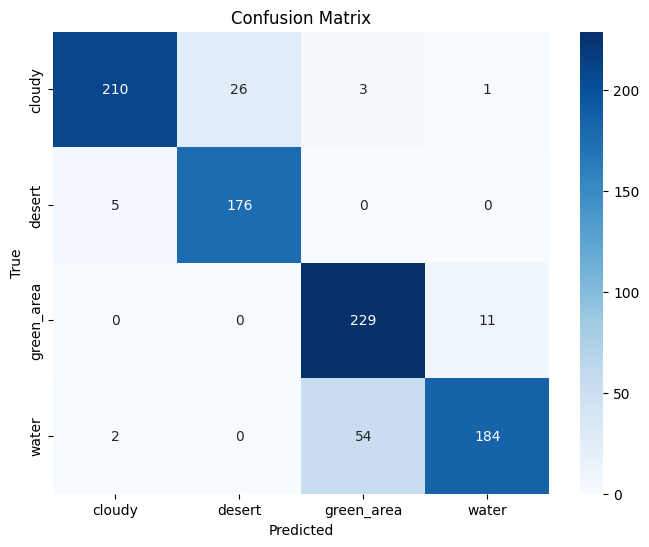


Classification Report:
              precision    recall  f1-score   support

      cloudy       0.97      0.88      0.92       240
      desert       0.87      0.97      0.92       181
  green_area       0.80      0.95      0.87       240
       water       0.94      0.77      0.84       240

    accuracy                           0.89       901
   macro avg       0.89      0.89      0.89       901
weighted avg       0.90      0.89      0.89       901



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict the classes on validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(y_val, axis=1)   # True class labels

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Compute and print classification report (includes F1 Score)
class_report = classification_report(y_true_classes, y_pred_classes, target_names=categories)
print("\nClassification Report:")
print(class_report)
